In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-29 15:27:59.544689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 15:28:00.137142: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-29 15:28:00.798661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 15:28:00.823400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
tf.keras.backend.clear_session()

In [4]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [5]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [6]:
subject = 'Rondônia - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [7]:
data = pd.read_csv('2003_mo_model_input_RO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego
0,2003-1,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,0.636082,4.987,571416.488347,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,13.867,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062
1,2003-2,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,0.636393,4.987,576005.312715,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,10.777,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943
2,2003-3,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,0.636703,4.987,580594.137083,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,13.888,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823
3,2003-4,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,0.637014,4.987,585182.961451,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,11.859,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703
4,2003-5,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,0.637324,4.987,589771.785820,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,14.431,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


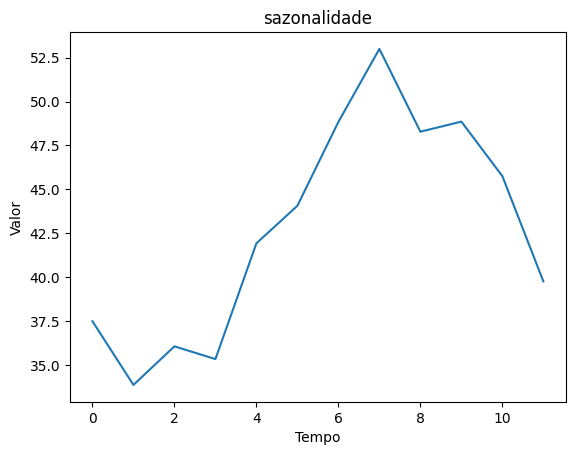

,sazonalidade
sazonalidade,
0,37.484568
1,33.856379
2,36.053154
3,35.327587
4,41.923759
5,44.063440
6,48.840487
7,52.998027
8,48.282743


In [8]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [9]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade,Rondônia - Consumo de Cimento (t)
0,2003-1,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,0.636082,4.987,571416.488347,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062,37.484568,13.867
1,2003-2,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,0.636393,4.987,576005.312715,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943,33.856379,10.777
2,2003-3,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,0.636703,4.987,580594.137083,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823,36.053154,13.888
3,2003-4,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,0.637014,4.987,585182.961451,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703,35.327587,11.859
4,2003-5,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,0.637324,4.987,589771.785820,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584,41.923759,14.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.923759,NaN
245,2023-6,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.063440,NaN
246,2023-7,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.840487,NaN
247,2023-8,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.998027,NaN


In [10]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      21.211
1      15.823
2      15.195
3      15.479
4      18.536
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Rondônia - Consumo de Cimento (t), Length: 249, dtype: float64

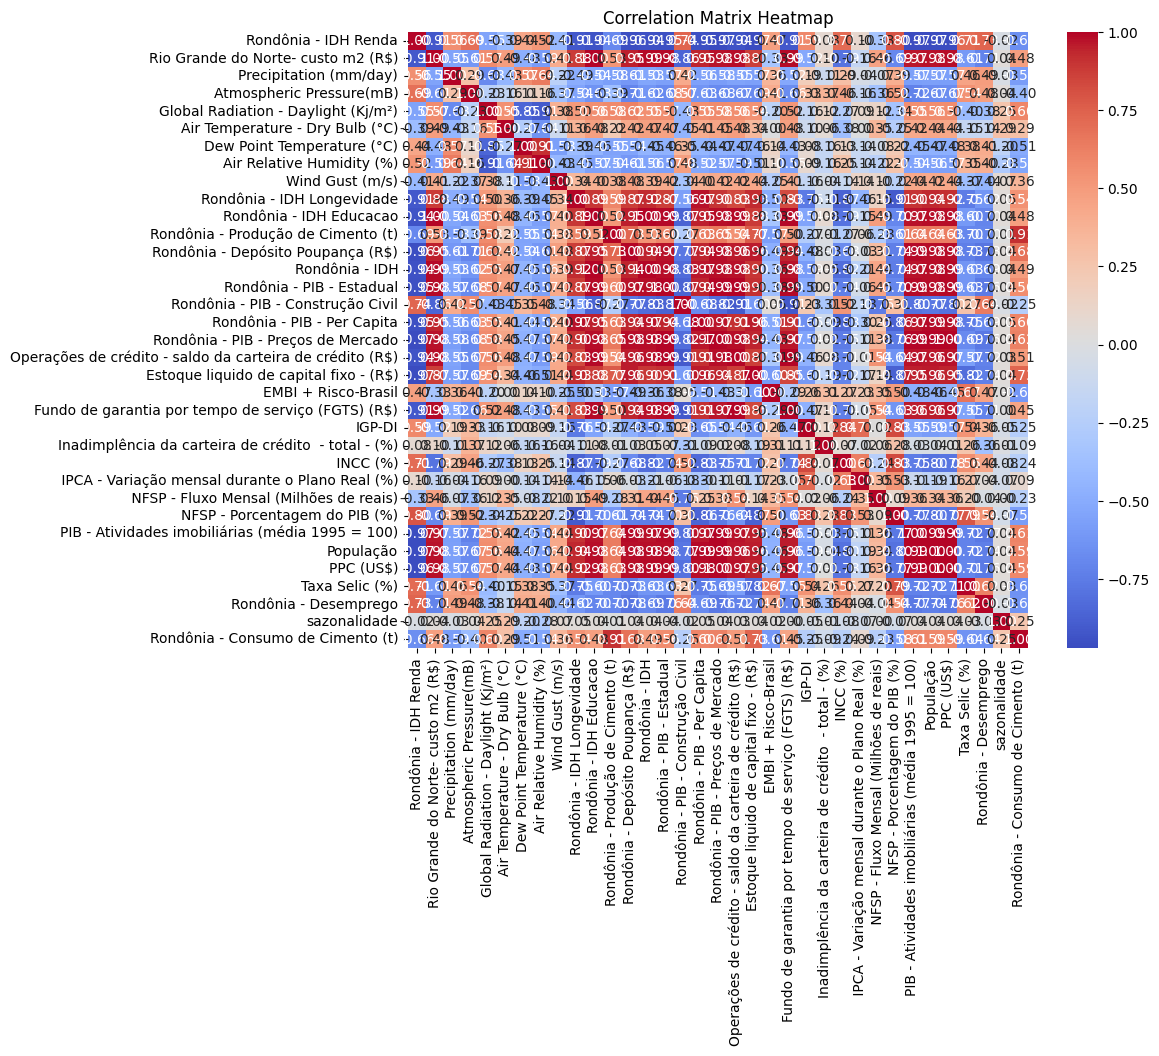

In [11]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [13]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rondônia - IDH Renda,1.455253e+03
1,Rio Grande do Norte- custo m2 (R$),6.954716e+04
2,Precipitation (mm/day),4.518843e+00
3,Atmospheric Pressure(mB),2.888777e+01
4,Global Radiation - Daylight (Kj/m²),1.866648e+01
5,Air Temperature - Dry Bulb (°C),5.799943e+02
6,Dew Point Temperature (°C),1.805103e+03
7,Air Relative Humidity (%),3.251120e+03
8,Wind Gust (m/s),6.883482e+00
9,Rondônia - IDH Longevidade,7.543465e+04


In [14]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 1


,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade
0,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,0.636082,4.987000,5.714165e+05,0.688843,2.068350e+07,1.587672e+06,11.468162,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062,37.484568
1,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,0.636393,4.987000,5.760053e+05,0.689031,2.071062e+07,1.589518e+06,11.472453,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943,33.856379
2,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,0.636703,4.987000,5.805941e+05,0.689218,2.073774e+07,1.591364e+06,11.476744,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823,36.053154
3,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,0.637014,4.987000,5.851830e+05,0.689405,2.076486e+07,1.593210e+06,11.481034,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703,35.327587
4,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,0.637324,4.987000,5.897718e+05,0.689592,2.079198e+07,1.595056e+06,11.485325,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584,41.923759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.693480,22667.876931,2.884937,998.137760,1426.148773,27.866873,20.937177,69.775359,1.554874,0.757185,0.695237,18.811821,1.938675e+06,0.714578,2.512984e+07,1.460038e+06,11.831960,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,7.206312,52.998027
176,0.693534,22768.661519,2.754614,997.206849,1381.384566,27.297461,21.458849,73.582594,1.518833,0.757057,0.695210,18.689723,1.949784e+06,0.714532,2.512400e+07,1.460807e+06,11.831498,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,7.195485,48.282743
177,0.693588,22873.012843,2.488907,995.917452,1343.337375,26.981998,21.780570,75.917458,1.546360,0.756929,0.695183,18.542721,1.960893e+06,0.714486,2.511815e+07,1.461577e+06,11.831036,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,7.184659,48.856456
178,0.693642,22977.830604,2.649317,994.690009,1255.740522,26.632116,22.107307,78.460340,1.564033,0.75680

In [15]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade
0,-1.584243,0.466959,1.529930,-0.057559,-0.417934,-0.509593,-0.283190,0.043111,-2.640969,-1.629338,-1.098891,-1.574780,-1.823039,-1.632278,0.283496,-2.350850,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,1.189771,-0.875038
1,-1.559883,0.463663,1.522973,-0.055679,-0.416574,-0.509569,-0.283607,0.044474,-2.582334,-1.612565,-1.098891,-1.565624,-1.798540,-1.614104,0.308885,-2.307809,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,1.176245,-1.476164
2,-1.536844,0.461741,1.518915,-0.054582,-0.415781,-0.509555,-0.283850,0.045269,-2.523700,-1.595791,-1.098891,-1.556467,-1.774041,-1.595929,0.334273,-2.264769,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,1.162719,-1.112198
3,-1.515574,0.461535,1.518480,-0.054465,-0.415696,-0.509554,-0.283876,0.045354,-2.465065,-1.579018,-1.098891,-1.547310,-1.749542,-1.577755,0.359661,-2.221729,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,1.149193,-1.232411
4,-1.495865,0.472759,1.505136,-0.065196,-0.409662,-0.487588,-0.267960,0.028375,-2.406431,-1.562244,-1.098891,-1.538154,-1.725043,-1.559580,0.385049,-2.178689,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,1.135667,-0.139545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.840653,-0.076421,0.006695,1.273660,2.548950,-1.293910,-2.032605,0.806042,1.112706,1.566690,-0.216507,1.153482,1.544497,1.347401,-1.471890,1.298474,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,-1.064141,1.695261
176,1.867782,-0.386745,-0.089394,0.963461,1.683293,-0.888698,-1.413607,0.693888,1.087158,1.565228,-0.224300,1.175649,1.538451,1.343485,-1.461306,1.293839,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,-1.088071,0.914023
177,1.895870,-1.019446,-0.222487,0.699808,1.203707,-0.638799,-1.033994,0.779548,1.061610,1.563765,-0.233683,1.197816,1.532406,1.339569,-1.450723,1.289204,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,-1.112000,1.009077
178,1.924084,-0.637479,-0.349184,0.092795,0.671793,-0.385004,-0.620560,0.834543,1.036063,1.562303,-0.246837,1.219983,1.526361,1.335653,-1.440140,1.284569,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,-1.135929,0.494413


In [16]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade
0,-1.584243,0.466959,1.529930,-0.057559,-0.417934,-0.509593,-0.283190,0.043111,-2.640969,-1.629338,-1.098891,-1.574780,-1.823039,-1.632278,0.283496,-2.350850,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,1.189771,-0.875038
1,-1.559883,0.463663,1.522973,-0.055679,-0.416574,-0.509569,-0.283607,0.044474,-2.582334,-1.612565,-1.098891,-1.565624,-1.798540,-1.614104,0.308885,-2.307809,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,1.176245,-1.476164
2,-1.536844,0.461741,1.518915,-0.054582,-0.415781,-0.509555,-0.283850,0.045269,-2.523700,-1.595791,-1.098891,-1.556467,-1.774041,-1.595929,0.334273,-2.264769,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,1.162719,-1.112198
3,-1.515574,0.461535,1.518480,-0.054465,-0.415696,-0.509554,-0.283876,0.045354,-2.465065,-1.579018,-1.098891,-1.547310,-1.749542,-1.577755,0.359661,-2.221729,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,1.149193,-1.232411
4,-1.495865,0.472759,1.505136,-0.065196,-0.409662,-0.487588,-0.267960,0.028375,-2.406431,-1.562244,-1.098891,-1.538154,-1.725043,-1.559580,0.385049,-2.178689,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,1.135667,-0.139545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.490068,-0.445478,-0.028125,1.248918,0.516755,-0.987025,-0.976309,0.006059,1.387870,1.568623,-0.161674,0.954867,1.587260,1.348174,-1.572438,1.232992,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,-0.563646,1.695261
164,1.519607,-0.465548,-0.114991,1.053037,0.489133,-0.668003,-0.748719,0.118611,1.368604,1.570284,-0.158941,0.963556,1.587171,1.353501,-1.567145,1.252578,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,-0.630244,0.914023
165,1.550008,-0.776626,-0.233109,0.777414,0.430920,-0.437660,-0.539648,0.148422,1.349338,1.571945,-0.157096,0.972246,1.587081,1.358829,-1.561852,1.272164,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,-0.696842,1.009077
166,1.580649,-0.642920,-0.349852,0.339047,0.094191,-0.291832,-0.292727,0.222478,1.330072,1.573606,-0.161536,0.980935,1.586992,1.364157,-1.556559,1.291749,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,-0.763439,0.494413


In [17]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      21.211
1      15.823
2      15.195
3      15.479
4      18.536
        ...  
163    39.293
164    41.610
165    43.544
166    35.658
167    29.693
Name: Rondônia - Consumo de Cimento (t), Length: 168, dtype: float64

In [18]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [19]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 32)

In [20]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade
132,0.725975,-0.752115,-3.610908,-0.005465,-0.472802,-0.114509,0.079391,0.587827,0.327452,0.765680,0.718677,1.222614,0.678933,0.983681,-0.991059,0.648927,0.992500,0.965586,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.848407,0.878252,-0.590376,-0.885224,-0.875038
133,0.747590,-0.725221,-3.363686,-0.149860,-0.560428,-0.071080,0.154509,0.368825,0.311181,0.785720,0.671074,1.206911,0.693440,0.999476,-1.023932,0.666384,1.013803,0.962419,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.861179,0.887574,-0.476859,-0.817584,-1.476164
134,0.769769,-0.936956,-2.932650,0.191296,-0.637443,-0.131624,0.141922,0.172342,0.294911,0.805760,0.631009,1.191208,0.707946,1.015272,-1.056805,0.683841,1.036490,0.959252,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.873950,0.896990,-0.089952,-0.749944,-1.112198
135,0.791168,-1.144644,-2.379330,0.286286,-0.862157,-0.380304,0.035784,0.010745,0.278640,0.825799,0.590391,1.175505,0.722453,1.031067,-1.089678,0.701298,1.059637,0.956085,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.886722,0.906245,-0.814200,-0.682304,-1.232411
136,0.812778,-0.739125,-1.796218,0.601197,-0.805966,-0.738520,-0.262018,-0.060678,0.262369,0.845839,0.548958,1.159803,0.736959,1.046862,-1.122551,0.718755,1.080606,0.952918,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.899493,0.915208,-0.917944,-0.614664,-0.139545
137,0.834356,-0.625008,-1.241106,0.930532,-0.480694,-0.935912,-0.555307,-0.090044,0.246098,0.865879,0.506886,1.144100,0.751466,1.062657,-1.155424,0.736212,1.101264,0.949751,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.912265,0.924126,-0.708692,-0.547024,0.214961
138,0.855323,0.186830,-0.979871,1.013787,-0.321672,-0.956506,-0.650027,-0.081786,0.229827,0.885918,0.464614,1.128397,0.765972,1.078452,-1.188297,0.753669,1.123860,0.946584,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.925036,0.932114,-0.496126,-0.479384,1.006432
139,0.877843,0.438720,-1.066928,1.006776,0.033327,-0.766885,-0.659582,-0.042243,0.213556,0.905958,0.422280,1.112694,0.780479,1.094247,-1.221170,0.771126,1.150086,0.943417,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.937808,0.939863,-0.251065,-0.411744,1.695261
140,0.900686,0.663679,-1.345479,0.528633,0.337304,-0.243018,-0.372008,0.032451,0.197285,0.925998,0.380004,1.096991,0.794985,1.110042,-1.254043,0.788584,1.179474,0.940250,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.950580,0.947944,-0.593206,-0.344104,0.914023
141,0.923680,0.607927,-1.321147,0.239305,1.341404,0.423200,-0.280272,0.314087,0.181014,0.946037,0.338080,1.081289,0.809492,1.125837,-1.286916,0.806041,1.214576,0.937082,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.963351,0.956229,-0.100794,-0.276464,1.009077


In [21]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 32)

In [22]:
def lstm_model(train_input, train_target, 
               first_layer_n_cells, 
               second_layer_n_cells,
               third_layer_n_cells,
               want_verbose=1, seed=0):
    
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=500,
        verbose=want_verbose,
        restore_best_weights=True,
        start_from_epoch=500
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(
        first_layer_n_cells,
        activation='tanh',
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        input_shape=(train_input.shape[1], train_input.shape[2])
    ))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(
        second_layer_n_cells,
        activation='tanh',
        return_sequences=(third_layer_n_cells > 0),
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))
        
    if third_layer_n_cells > 0:
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.LSTM(
            third_layer_n_cells,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')    
    history = model.fit(
        train_input,
        train_target,
        epochs=10000,
        validation_split=0.07,
        callbacks=[early_stopping],
        verbose=want_verbose
    )
    
    return model, history

In [23]:
def get_a_good_seed(train_input, train_target, first_layer_n_cells, second_layer_n_cells, third_layer_n_cells):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(3)]
    list_loss = []
    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, 
                                    first_layer_n_cells, second_layer_n_cells, third_layer_n_cells,
                                    want_verbose=0, seed=seed)
        
        current_loss = min(history.history['val_loss'][500:])
        list_loss.append(current_loss)
        print(f"val_loss: {current_loss}")
        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed, np.mean(list_loss)

    return winner_seed, np.mean(sorted(list_loss)[:2])

In [24]:
# Tuning range
first_layer_cells_list = [36, 72, 144]
second_layer_cells_list = [36, 72, 144]
third_layer_cells_list = [0, 36, 72, 144]

In [25]:
def hyperparameter_tuning(train_input, train_target, 
                          first_layer_cells_list, second_layer_cells_list, third_layer_cells_list):
    
    best_loss = float('inf')
    best_combination = None
    
    for first_cells in first_layer_cells_list:
        for second_cells in second_layer_cells_list:
            for third_cells in third_layer_cells_list:
                if not third_cells > second_cells:
                    print(f"_________________________________________________________________________________________")
                    print(" ")
                    print(f" Testing [{first_cells}, {second_cells}, {third_cells}]")
                    print(f"_________________________________________________________________________________________")

                    winner_seed, mean_loss = get_a_good_seed(train_input, train_target, 
                                                                first_cells, second_cells, third_cells)
                    print(" ")
                    print(f"first_layer_n_cells: {first_cells}")
                    print(f"second_layer_n_cells: {second_cells}")
                    print(f"third_layer_n_cells: {third_cells}")
                    if mean_loss < best_loss:
                        best_loss = mean_loss
                        best_combination = [first_cells, second_cells, third_cells, winner_seed]
                        print(f"best_loss: {best_loss}")
                        print(f"winner_seed: {winner_seed}")
                    print(" ")
            
    return best_combination

In [26]:
best_combination = hyperparameter_tuning(reshaped_train, 
                                         reshaped_target, 
                                         first_layer_cells_list, 
                                         second_layer_cells_list, 
                                         third_layer_cells_list)
best_combination

_________________________________________________________________________________________
 
 Testing [36, 36, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________


2023-11-29 15:28:03.386893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 15:28:03.387158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 15:28:03.387344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

val_loss: 26.67719078063965
winner_seed: 2005389370


Step: 1 ___________________________________________
val_loss: 19.43853759765625
winner_seed: 3421734999


Step: 2 ___________________________________________
val_loss: 9.471563339233398
winner_seed: 776559138
 
first_layer_n_cells: 36
second_layer_n_cells: 36
third_layer_n_cells: 0
best_loss: 14.455050468444824
winner_seed: 776559138
 
_________________________________________________________________________________________
 
 Testing [36, 36, 36]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 71.09786987304688
winner_seed: 2195974409


Step: 1 ___________________________________________
val_loss: 25.47663688659668
winner_seed: 2483957155


Step: 2 ___________________________________________
val_loss: 10.727937698364258
winner_seed: 2342161016
 
first_layer_n_cells: 36
second_layer_n_cells: 36
third_layer_n_cells: 36
 
________

val_loss: 15.189653396606445
winner_seed: 3323027863


Step: 1 ___________________________________________
val_loss: 11.124587059020996
winner_seed: 3521119289


Step: 2 ___________________________________________
val_loss: 15.032371520996094
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 0
 
_________________________________________________________________________________________
 
 Testing [72, 144, 36]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 16.21324920654297
winner_seed: 2002937485


Step: 1 ___________________________________________
val_loss: 25.37983512878418


Step: 2 ___________________________________________
val_loss: 17.453638076782227
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 36
 
_________________________________________________________________________________________
 
 Testing [72, 144, 72]
___________

[36, 72, 36, 756733651]

In [27]:
best_combination

[36, 72, 36, 756733651]

In [28]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target,
                                    best_combination[0], best_combination[1], best_combination[2],
                                    want_verbose=1, 
                                    seed=best_combination[3])

Epoch 1/10000
4/4 [==============================] - 3s 177ms/step - loss: 3463.3860 - val_loss: 925.1776
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 3039.1643 - val_loss: 730.3942
Epoch 3/10000
4/4 [==============================] - 0s 12ms/step - loss: 2815.7593 - val_loss: 646.7497
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 2689.3103 - val_loss: 599.8869
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 2606.2632 - val_loss: 564.1129
Epoch 6/10000
4/4 [==============================] - 0s 12ms/step - loss: 2536.4810 - val_loss: 531.1459
Epoch 7/10000
4/4 [==============================] - 0s 11ms/step - loss: 2471.2505 - val_loss: 499.8746
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 2404.4136 - val_loss: 470.2596
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 2341.9070 - val_loss: 441.8168
Epoch 10/10000
4/4 [==============================] - 

Epoch 79/10000
4/4 [==============================] - 0s 11ms/step - loss: 583.0086 - val_loss: 250.7952
Epoch 80/10000
4/4 [==============================] - 0s 11ms/step - loss: 578.7153 - val_loss: 258.5122
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 574.4020 - val_loss: 266.3098
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 569.2441 - val_loss: 273.5719
Epoch 83/10000
4/4 [==============================] - 0s 10ms/step - loss: 565.2643 - val_loss: 280.8766
Epoch 84/10000
4/4 [==============================] - 0s 12ms/step - loss: 560.9415 - val_loss: 287.8611
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 557.7654 - val_loss: 295.6467
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 553.6367 - val_loss: 303.6976
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 549.6339 - val_loss: 312.0041
Epoch 88/10000
4/4 [==============================] - 0

4/4 [==============================] - 0s 13ms/step - loss: 497.9434 - val_loss: 569.2954
Epoch 157/10000
4/4 [==============================] - 0s 11ms/step - loss: 497.8845 - val_loss: 569.6614
Epoch 158/10000
4/4 [==============================] - 0s 13ms/step - loss: 497.8742 - val_loss: 570.5939
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 497.8741 - val_loss: 571.5180
Epoch 160/10000
4/4 [==============================] - 0s 12ms/step - loss: 497.8448 - val_loss: 572.3161
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 497.8264 - val_loss: 572.8007
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 497.8464 - val_loss: 573.8491
Epoch 163/10000
4/4 [==============================] - 0s 11ms/step - loss: 497.8139 - val_loss: 574.5838
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 497.7872 - val_loss: 574.6611
Epoch 165/10000
4/4 [==============================] - 0s 11ms

Epoch 234/10000
4/4 [==============================] - 0s 10ms/step - loss: 122.2591 - val_loss: 29.9356
Epoch 235/10000
4/4 [==============================] - 0s 10ms/step - loss: 119.6963 - val_loss: 26.8667
Epoch 236/10000
4/4 [==============================] - 0s 10ms/step - loss: 119.6142 - val_loss: 33.9813
Epoch 237/10000
4/4 [==============================] - 0s 11ms/step - loss: 119.8723 - val_loss: 34.5703
Epoch 238/10000
4/4 [==============================] - 0s 11ms/step - loss: 119.3416 - val_loss: 35.4220
Epoch 239/10000
4/4 [==============================] - 0s 11ms/step - loss: 112.8623 - val_loss: 36.6473
Epoch 240/10000
4/4 [==============================] - 0s 12ms/step - loss: 110.3853 - val_loss: 37.5639
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 112.7815 - val_loss: 32.2394
Epoch 242/10000
4/4 [==============================] - 0s 11ms/step - loss: 109.4991 - val_loss: 28.0832
Epoch 243/10000
4/4 [==============================] - 

4/4 [==============================] - 0s 10ms/step - loss: 54.6440 - val_loss: 31.2195
Epoch 313/10000
4/4 [==============================] - 0s 10ms/step - loss: 49.8206 - val_loss: 29.3689
Epoch 314/10000
4/4 [==============================] - 0s 11ms/step - loss: 51.9499 - val_loss: 26.8508
Epoch 315/10000
4/4 [==============================] - 0s 11ms/step - loss: 48.4132 - val_loss: 27.7745
Epoch 316/10000
4/4 [==============================] - 0s 11ms/step - loss: 52.5016 - val_loss: 29.3761
Epoch 317/10000
4/4 [==============================] - 0s 12ms/step - loss: 48.7362 - val_loss: 30.6529
Epoch 318/10000
4/4 [==============================] - 0s 12ms/step - loss: 50.5948 - val_loss: 29.4171
Epoch 319/10000
4/4 [==============================] - 0s 10ms/step - loss: 49.4931 - val_loss: 28.3219
Epoch 320/10000
4/4 [==============================] - 0s 16ms/step - loss: 52.4984 - val_loss: 32.6298
Epoch 321/10000
4/4 [==============================] - 0s 10ms/step - loss: 48.2

Epoch 391/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.6897 - val_loss: 31.1464
Epoch 392/10000
4/4 [==============================] - 0s 11ms/step - loss: 34.5970 - val_loss: 25.7559
Epoch 393/10000
4/4 [==============================] - 0s 11ms/step - loss: 37.0863 - val_loss: 25.4357
Epoch 394/10000
4/4 [==============================] - 0s 10ms/step - loss: 34.2083 - val_loss: 26.4599
Epoch 395/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.8847 - val_loss: 26.8471
Epoch 396/10000
4/4 [==============================] - 0s 11ms/step - loss: 31.7939 - val_loss: 27.3139
Epoch 397/10000
4/4 [==============================] - 0s 11ms/step - loss: 32.7917 - val_loss: 27.0353
Epoch 398/10000
4/4 [==============================] - 0s 11ms/step - loss: 32.8912 - val_loss: 25.5481
Epoch 399/10000
4/4 [==============================] - 0s 11ms/step - loss: 33.2987 - val_loss: 20.1363
Epoch 400/10000
4/4 [==============================] - 0s 10ms/s

Epoch 470/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.7475 - val_loss: 19.9282
Epoch 471/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.0569 - val_loss: 20.6634
Epoch 472/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.3932 - val_loss: 27.7630
Epoch 473/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.5697 - val_loss: 26.4554
Epoch 474/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.8110 - val_loss: 27.8318
Epoch 475/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.4789 - val_loss: 25.8668
Epoch 476/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.9346 - val_loss: 23.2238
Epoch 477/10000
4/4 [==============================] - 0s 12ms/step - loss: 24.8846 - val_loss: 23.4099
Epoch 478/10000
4/4 [==============================] - 0s 12ms/step - loss: 23.6680 - val_loss: 22.2380
Epoch 479/10000
4/4 [==============================] - 0s 11ms/s

Epoch 549/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.9284 - val_loss: 15.4993
Epoch 550/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.0637 - val_loss: 16.7158
Epoch 551/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.5693 - val_loss: 19.7285
Epoch 552/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.2252 - val_loss: 19.5523
Epoch 553/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.4547 - val_loss: 18.8860
Epoch 554/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.9616 - val_loss: 19.7653
Epoch 555/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.3528 - val_loss: 19.5236
Epoch 556/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.6150 - val_loss: 19.3647
Epoch 557/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.6945 - val_loss: 19.7356
Epoch 558/10000
4/4 [==============================] - 0s 10ms/s

Epoch 628/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.3388 - val_loss: 20.0740
Epoch 629/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.6275 - val_loss: 19.1304
Epoch 630/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.6833 - val_loss: 19.9517
Epoch 631/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.1633 - val_loss: 19.5142
Epoch 632/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.6934 - val_loss: 17.6215
Epoch 633/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.3460 - val_loss: 18.5835
Epoch 634/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.0172 - val_loss: 19.3444
Epoch 635/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.0636 - val_loss: 17.6746
Epoch 636/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.8663 - val_loss: 17.1717
Epoch 637/10000
4/4 [==============================] - 0s 10ms/s

Epoch 707/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.1487 - val_loss: 16.1304
Epoch 708/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.4996 - val_loss: 15.5532
Epoch 709/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.6292 - val_loss: 15.3669
Epoch 710/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.4466 - val_loss: 16.2470
Epoch 711/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.0840 - val_loss: 16.2601
Epoch 712/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.1886 - val_loss: 15.4625
Epoch 713/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.4875 - val_loss: 13.2155
Epoch 714/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.6906 - val_loss: 12.7242
Epoch 715/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.7098 - val_loss: 16.0419
Epoch 716/10000
4/4 [==============================] - 0s 11ms/s

Epoch 786/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.0450 - val_loss: 11.2836
Epoch 787/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.2903 - val_loss: 14.8095
Epoch 788/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.5397 - val_loss: 17.7289
Epoch 789/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.8980 - val_loss: 22.8337
Epoch 790/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.5601 - val_loss: 17.5858
Epoch 791/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.2994 - val_loss: 15.3456
Epoch 792/10000
4/4 [==============================] - 0s 13ms/step - loss: 10.7211 - val_loss: 15.1477
Epoch 793/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.7518 - val_loss: 16.5498
Epoch 794/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.7419 - val_loss: 14.0677
Epoch 795/10000
4/4 [==============================] - 0s 11ms/st

4/4 [==============================] - 0s 11ms/step - loss: 7.9237 - val_loss: 14.1904
Epoch 866/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.9837 - val_loss: 13.0967
Epoch 867/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.6558 - val_loss: 13.6229
Epoch 868/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.8677 - val_loss: 13.2762
Epoch 869/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.4197 - val_loss: 12.7693
Epoch 870/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.1606 - val_loss: 13.2410
Epoch 871/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.7677 - val_loss: 22.3968
Epoch 872/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.4095 - val_loss: 25.3448
Epoch 873/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.2603 - val_loss: 23.1534
Epoch 874/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.9558 - val_

4/4 [==============================] - 0s 11ms/step - loss: 4.8108 - val_loss: 15.8346
Epoch 945/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2780 - val_loss: 13.1249
Epoch 946/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8191 - val_loss: 13.6890
Epoch 947/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.6708 - val_loss: 14.7884
Epoch 948/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.3052 - val_loss: 15.1243
Epoch 949/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.3712 - val_loss: 13.0232
Epoch 950/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.8691 - val_loss: 11.5154
Epoch 951/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8248 - val_loss: 12.5112
Epoch 952/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.6326 - val_loss: 13.3157
Epoch 953/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8185 - val_

4/4 [==============================] - 0s 12ms/step - loss: 5.0063 - val_loss: 18.2553
Epoch 1024/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.5662 - val_loss: 20.6175
Epoch 1025/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.6177 - val_loss: 18.7006
Epoch 1026/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.5644 - val_loss: 17.6993
Epoch 1027/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5896 - val_loss: 15.6666
Epoch 1028/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.9382 - val_loss: 13.6893
Epoch 1029/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.5294 - val_loss: 14.1097
Epoch 1030/10000
4/4 [==============================] - 0s 15ms/step - loss: 5.6844 - val_loss: 17.7428
Epoch 1031/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4344 - val_loss: 21.3400
Epoch 1032/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.46

Epoch 1102/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1389 - val_loss: 11.8375
Epoch 1103/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6290 - val_loss: 11.5674
Epoch 1104/10000
4/4 [==============================] - 0s 13ms/step - loss: 7.6900 - val_loss: 28.4977
Epoch 1105/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.2351 - val_loss: 37.8893
Epoch 1106/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.8320 - val_loss: 34.6101
Epoch 1107/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.6447 - val_loss: 21.0904
Epoch 1108/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.1115 - val_loss: 16.0839
Epoch 1109/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.7818 - val_loss: 17.6362
Epoch 1110/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.0443 - val_loss: 18.9901
Epoch 1111/10000
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 11ms/step - loss: 9.8492 - val_loss: 15.3567
Epoch 1181/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.2946 - val_loss: 17.2975
Epoch 1182/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6465 - val_loss: 19.2612
Epoch 1183/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.1242 - val_loss: 19.2904
Epoch 1184/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.0501 - val_loss: 19.6466
Epoch 1185/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.6182 - val_loss: 20.2205
Epoch 1186/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.2975 - val_loss: 16.6014
Epoch 1187/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.8918 - val_loss: 14.5590
Epoch 1188/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.9238 - val_loss: 14.0491
Epoch 1189/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.45

Epoch 1259/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.6577 - val_loss: 30.1692
Epoch 1260/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2186 - val_loss: 21.8503
Epoch 1261/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.0002 - val_loss: 18.8574
Epoch 1262/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5974 - val_loss: 20.2098
Epoch 1263/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8367 - val_loss: 25.5879
Epoch 1264/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.3071 - val_loss: 28.6043
Epoch 1265/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.1524 - val_loss: 24.4084
Epoch 1266/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.8006 - val_loss: 18.4962
Epoch 1267/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.0340 - val_loss: 15.5225
Epoch 1268/10000
4/4 [==============================] - 0s 11ms/

Epoch 1338/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.2203 - val_loss: 20.0976
Epoch 1339/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4332 - val_loss: 20.6708
Epoch 1340/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9264 - val_loss: 21.7964
Epoch 1341/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1829 - val_loss: 22.4493
Epoch 1342/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1239 - val_loss: 21.5846
Epoch 1343/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1316 - val_loss: 18.8183
Epoch 1344/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.3154 - val_loss: 16.7132
Epoch 1345/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1332 - val_loss: 18.7522
Epoch 1346/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2785 - val_loss: 22.1031
Epoch 1347/10000
4/4 [==============================] - 0s 12ms/

Epoch 1417/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.8715 - val_loss: 30.0267
Epoch 1418/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.7000 - val_loss: 26.4900
Epoch 1419/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.8148 - val_loss: 27.3354
Epoch 1420/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.5553 - val_loss: 29.4260
Epoch 1421/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.0714 - val_loss: 30.9296
Epoch 1422/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.4978 - val_loss: 30.9530
Epoch 1423/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.7505 - val_loss: 30.0677
Epoch 1424/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1102 - val_loss: 29.0288
Epoch 1425/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8802 - val_loss: 29.5802
Epoch 1426/10000
4/4 [==============================] - 0s 11ms/

Epoch 1496/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.1899 - val_loss: 27.9460
Epoch 1497/10000
4/4 [==============================] - 0s 12ms/step - loss: 2.9468 - val_loss: 25.8307
Epoch 1498/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.0859 - val_loss: 27.8262
Epoch 1499/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2377 - val_loss: 29.0899
Epoch 1500/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9711 - val_loss: 27.4787
Epoch 1501/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.0982 - val_loss: 25.3561
Epoch 1502/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9192 - val_loss: 24.8652
Epoch 1503/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.0964 - val_loss: 25.5171
Epoch 1504/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.7499 - val_loss: 29.3212
Epoch 1505/10000
4/4 [==============================] - 0s 11ms/

Epoch 1575/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.7079 - val_loss: 23.4922
Epoch 1576/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.3279 - val_loss: 23.9938
Epoch 1577/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.7980 - val_loss: 26.9681
Epoch 1578/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6344 - val_loss: 32.6624
Epoch 1579/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.3980 - val_loss: 25.9504
Epoch 1580/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.4761 - val_loss: 24.8761
Epoch 1581/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.2500 - val_loss: 25.8709
Epoch 1582/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.5377 - val_loss: 24.9599
Epoch 1583/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.5339 - val_loss: 24.5197
Epoch 1584/10000
4/4 [==============================] - 0s 11ms/

In [29]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [30]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,24.605673,24.012735,23.137152,23.429449,24.841831,29.415743,32.908882,36.304024,41.591404,39.355515,35.960064,32.109306
Target,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,7.953325,0.897264,5.575848,9.230551,6.793169,5.726255,3.510117,3.995975,6.098404,0.866516,0.369064,4.579306


In [31]:
display(mae)
display(mape)

4.6329827

0.1417811